In [ ]:
!pip install torch torchvision numpy matplotlib 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])


In [3]:
# CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root=' ./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Split training set into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Data Loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

In [4]:
def imshow(img):
    """Show an image"""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


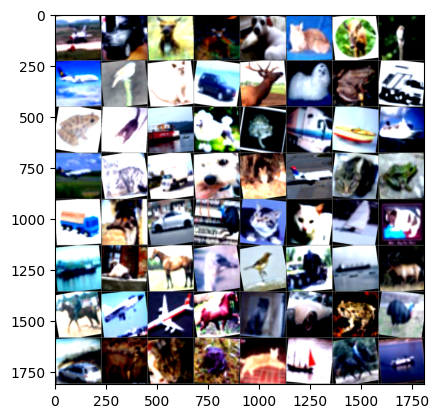

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

## MOBILENETV2

In [6]:
import torchvision.models as models
import torch.nn as nn


mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Final classification layer to 10 classes
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 10)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)
mobilenet_v2 = mobilenet_v2.to(device)
mobilenet_v2

mps


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
import copy


def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    num_epochs=25,
):
    """Train the model and return the best version based on validation accuracy."""

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
        )

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.show()

    return model, best_acc, train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/5, Train Loss: 0.5083, Train Acc: 0.8295, Val Loss: 0.3449, Val Acc: 0.8832
Epoch 2/5, Train Loss: 0.3134, Train Acc: 0.8933, Val Loss: 0.3186, Val Acc: 0.8891
Epoch 3/5, Train Loss: 0.2554, Train Acc: 0.9132, Val Loss: 0.2608, Val Acc: 0.9111
Epoch 4/5, Train Loss: 0.2217, Train Acc: 0.9231, Val Loss: 0.2797, Val Acc: 0.9040
Epoch 5/5, Train Loss: 0.2020, Train Acc: 0.9313, Val Loss: 0.2871, Val Acc: 0.9074
Best validation accuracy: 0.9111


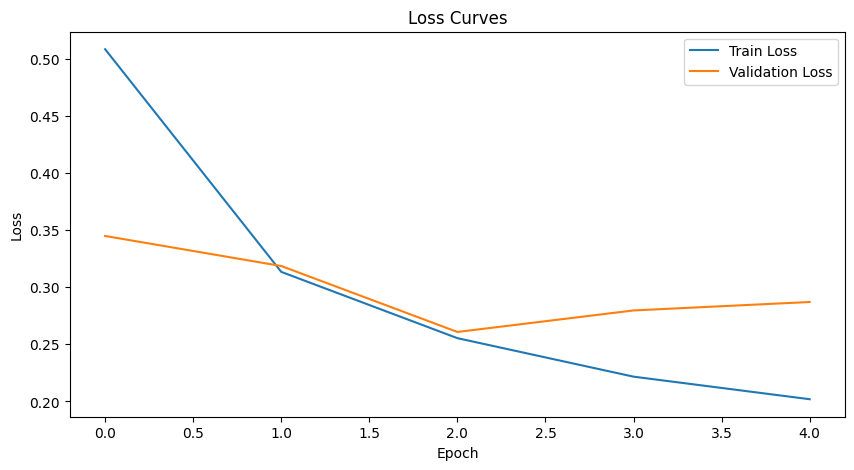

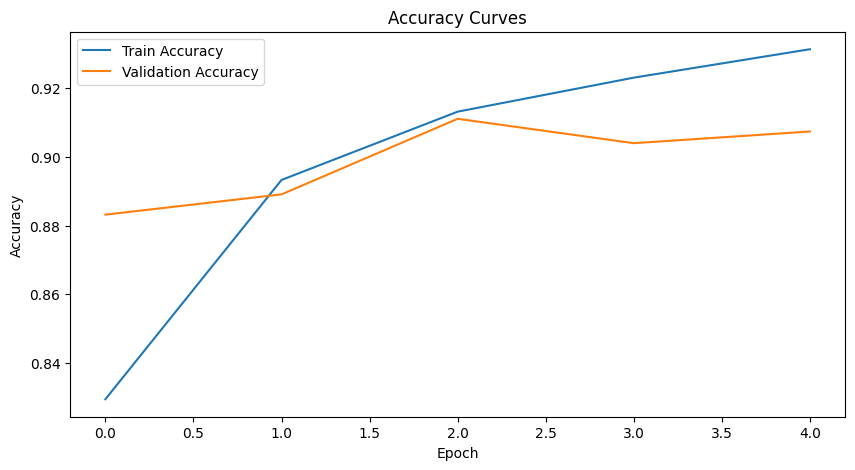

AttributeError: 'tuple' object has no attribute 'state_dict'

In [13]:
mobilenet_v2 = train_model(
    mobilenet_v2,
    criterion,
    optimizer,
    scheduler,
    trainloader,
    valloader,
    num_epochs=5,
)

torch.save(mobilenet_v2.state_dict(), "mobilenetv2_mps.pth")

In [15]:
mobilenet_v2 = mobilenet_v2[0]
torch.save(mobilenet_v2.state_dict(), "mobilenetv2_mps.pth")

Epoch 1/5, Train Loss: 0.2413, Train Acc: 0.9174, Val Loss: 0.2841, Val Acc: 0.9038
Epoch 2/5, Train Loss: 0.2024, Train Acc: 0.9309, Val Loss: 0.2621, Val Acc: 0.9139
Epoch 3/5, Train Loss: 0.0963, Train Acc: 0.9666, Val Loss: 0.1671, Val Acc: 0.9449
Epoch 4/5, Train Loss: 0.0640, Train Acc: 0.9781, Val Loss: 0.1615, Val Acc: 0.9474
Epoch 5/5, Train Loss: 0.0523, Train Acc: 0.9822, Val Loss: 0.1598, Val Acc: 0.9467
Best validation accuracy: 0.9474


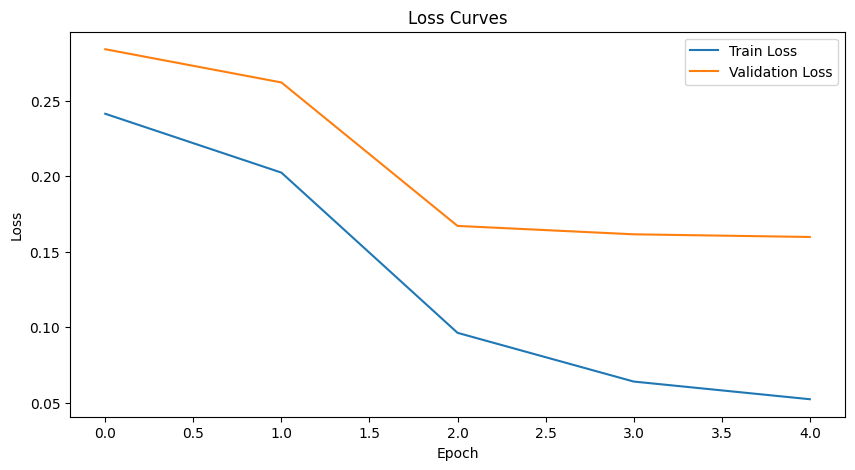

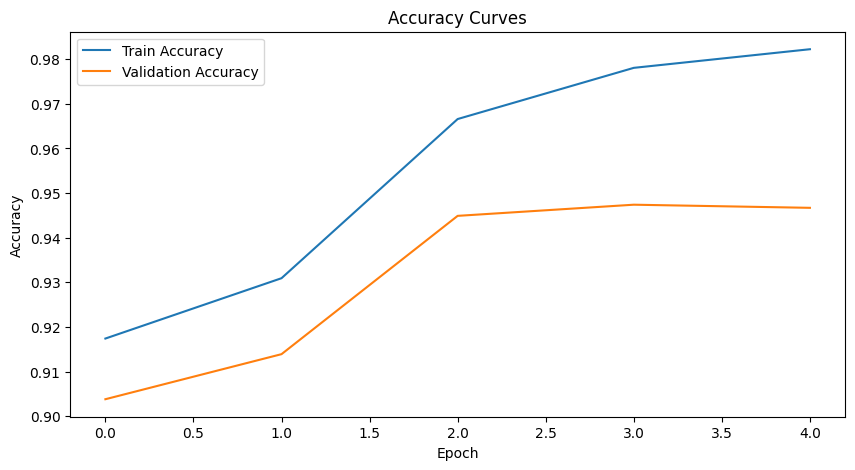

In [16]:
train_res = train_model(
    mobilenet_v2,
    criterion,
    optimizer,
    scheduler,
    trainloader,
    valloader,
    num_epochs=5,
)

mobilenet_v2 = train_res[0]
torch.save(mobilenet_v2.state_dict(), "mobilenetv2_mps.pth")

In [10]:
mobilenet_v2.load_state_dict(torch.load("mobilenetv2_mps.pth"))

<All keys matched successfully>

In [11]:
accuracy = evaluate_model(mobilenet_v2, testloader)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.70%


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def print_classification_report(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(classification_report(all_labels, all_preds, target_names=classes))

In [13]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Classification Report:
              precision    recall  f1-score   support

       plane       0.96      0.96      0.96      1000
         car       0.97      0.98      0.97      1000
        bird       0.95      0.93      0.94      1000
         cat       0.86      0.91      0.88      1000
        deer       0.95      0.95      0.95      1000
         dog       0.91      0.90      0.91      1000
        frog       0.97      0.97      0.97      1000
       horse       0.98      0.96      0.97      1000
        ship       0.96      0.96      0.96      1000
       truck       0.96      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion Matrix:


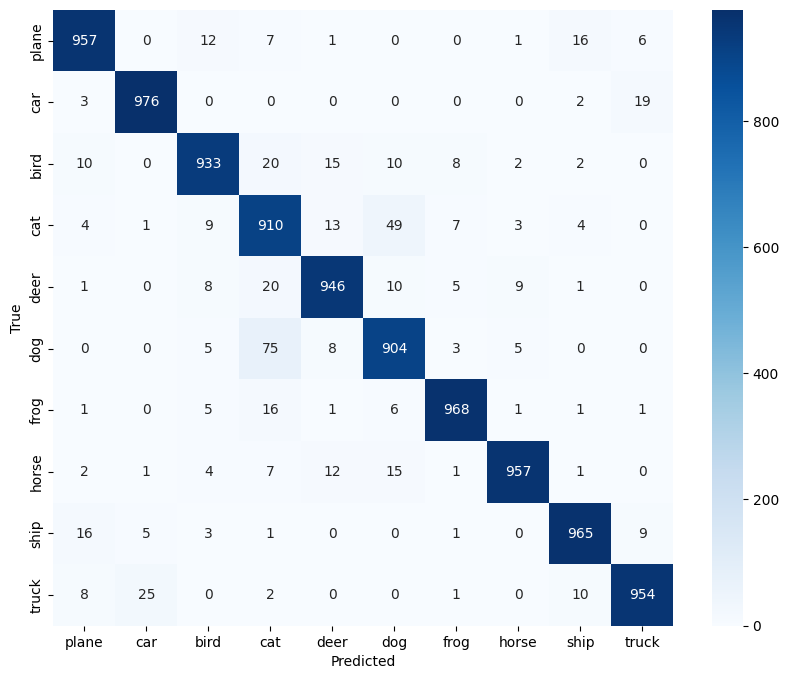

In [14]:
print("Classification Report:")
print_classification_report(mobilenet_v2, testloader, classes)
print("Confusion Matrix:")
plot_confusion_matrix(mobilenet_v2, testloader, classes)

In [15]:
def visualize_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {classes[preds[j]]}, True: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images * 2:
                    return

Sample Predictions and Misclassifications:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].


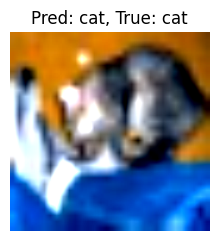

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].


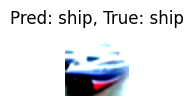

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].


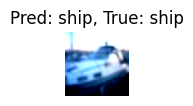

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6369936].


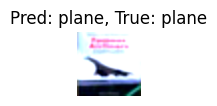

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901533..1.4079132].


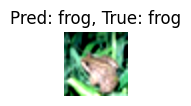

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].


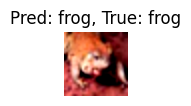

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].


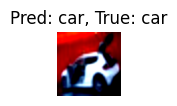

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.8025708].


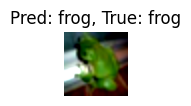

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39626682..1.6792717].


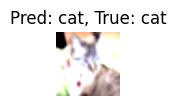

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37057972..1.7851416].


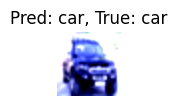

In [16]:
print("Sample Predictions and Misclassifications:")
visualize_predictions(mobilenet_v2, testloader, classes)

In [17]:
import time


def measure_inference_speed(model, dataloader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

In [18]:
inference_time_custom_cnn = measure_inference_speed(mobilenet_v2, testloader, device)
print(f'Inference Time: {inference_time_custom_cnn:.2f} seconds')


Inference Time: 34.61 seconds


In [19]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

In [20]:
model_size_custom_cnn = get_model_size(mobilenet_v2)
print(f'Model Size: {model_size_custom_cnn:.2f} MB')


Model Size: 8.66 MB


In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import time


mobilenet_v2 = models.mobilenet_v2(weights=None)
mobilenet_v2.classifier[1] = torch.nn.Linear(mobilenet_v2.classifier[1].in_features, 10)
mobilenet_v2.load_state_dict(torch.load("mobilenetv2_mps.pth"))
mobilenet_v2.eval()

device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
mobilenet_v2 = mobilenet_v2.to(device)

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam")
    exit()


print("Press 'q' to quit")


while True:

    ret, frame = cap.read()
    if not ret:
        print("Error: Can't receive frame")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    input_tensor = transform(frame_rgb)
    input_batch = input_tensor.unsqueeze(0).to(device)

    start_time = time.time()
    with torch.no_grad():
        output = mobilenet_v2(input_batch)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    top_prob, top_class = torch.max(probabilities, 0)

    fps = 1.0 / (time.time() - start_time)

    if top_prob < 0.5:
        class_name = "Unknown"
    else:
        class_name = classes[top_class.item()]

    prob = top_prob.item() * 100

    cv2.putText(
        frame,
        f"Class: {class_name}, {prob:.2f}%",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0),
        2,
    )
    cv2.putText(
        frame,
        f"FPS: {fps:.2f}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0),
        2,
    )

    cv2.imshow("MobileNetV2 Real-time Classification", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit


KeyboardInterrupt: 